<a href="https://colab.research.google.com/github/jvataidee/DataAnalysis/blob/master/Analise_Financeira_Mercado_Gado_de_Corte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**by: [João Ataíde](https://www.joaoataide.com)**
# Análise Mercado Financeira de Gado de Corte


---


## Importanto bibliotecas básicas

In [54]:
#importar bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from statsmodels.tsa.seasonal import seasonal_decompose

# configurar a visualização
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Obtenção dos dados

In [2]:
!pip install investpy -q

     |████████████████████████████████| 4.4 MB 9.5 MB/s 
     |████████████████████████████████| 241 kB 55.7 MB/s 
     |████████████████████████████████| 6.3 MB 60.4 MB/s 
     |████████████████████████████████| 510 kB 53.8 MB/s 


In [3]:
!pip install yfinance -q

In [4]:
#importar bibliotecas financeiras
import investpy
import yfinance as yf

### Dados de Commodities

Para fazer as análises do mercado de pecuária, diversas commodities são variáveis para o trabalho, sendo elas as seguintes:



*   `Live Cattle` - preço do Boi Gordo
*   `Feeder Cattle` - preço do Boi em engorda
*   `US Soybeans` - preço da soja
*   `US Corn` - preço do milho
*   `Dollar` - preço do Dollar/Real

Para importar esses dados usarei a biblioteca investpy, que possui um API com comandos para diversos dados financeiros. Para isso, precisaremos estipular uma janela de programação no qual precisa ser maior que 6 anos, devido ao ciclo da pecuária de corte.



In [5]:
#Lista de commodities
commodities = ["Live Cattle", "Feeder Cattle", "US Soybeans","US Corn"]

#Data de inicio e fim de análise
inicio = "01/01/2014"
fim = "31/12/2021"

In [6]:
#Função para importar dados das commodities
def commodities_df(commodities, inicio,fim):
  precos = pd.DataFrame()
  for i in commodities:
    df = investpy.commodities.get_commodity_historical_data(commodity=i, from_date=inicio, to_date=fim).Close
    df.rename(i, inplace=True)
    df.columns = [i]
    precos = pd.concat([precos,df], axis=1)
    precos.index.name="Date"
  return precos


#Data Frame de commodites
df = commodities_df(commodities,inicio,fim)

#Importar dollar
doll = yf.Ticker("USDBRL=x")
dollar = pd.DataFrame(doll.history(start ="2014-01-01", end ="2020-12-31" ).Close)
dollar.columns = ["Dollar"]
dollar.index.name="Date"

#merge dado
dados =pd.merge(df, dollar, how='inner', right_index=True, left_index=True)

#Agrupar a média por trimestre
dados_trimestre = dados.groupby(pd.Grouper(freq='Q')).mean()
dados_trimestre = dados_trimestre.reset_index()
dados_trimestre.head()

,Date,Live Cattle,Feeder Cattle,US Soybeans,US Corn,Dollar
0,2014-03-31,142.532871,171.350492,1351.535000,451.977903,2.361074
1,2014-06-30,142.672619,190.970476,1462.786349,479.190476,2.225935
2,2014-09-30,154.548047,220.610000,1089.502969,359.718750,2.268325
3,2014-12-31,165.997308,233.692187,1008.709385,372.705846,2.538731
4,2015-03-31,157.177049,210.525246,991.899180,384.864754,2.864362


### Dados do SIDRA

Outro dados importante é referente aos número de abates dos animais por classe dentro do intervalo de tempo, sendo usado então validar os ciclos e as sazonalidades das culturas. Para isso, precisaremos baixar todas as classes os dados referentes ao intervalo e cabeças abatidas de cada classe:

*   `Bois` - Animal macho
*   `Vacas` - Animal fêmea
*   `Novilhas` - Animal fêmea mais nova 
*   `Novilhos` - Animal macho mais novo
*   `Totais` -  Soma de todas as classes



In [7]:
#link do banco de dados sidra
consulta = 'https://apisidra.ibge.gov.br/values/t/1092/n1/all/v/all/p/all/c12716/all/c18/55,56,992,111734,111735/c12529/all/d/v1000151%202,v1000284%202,v1000285%202'
ufs = [5] #numero de consultas

#Baixar dados do sidra
df2 = pd.DataFrame()
for uf in ufs:
    url = consulta.format(uf)
    dados_json = requests.get(url).json()
    dados_pandas = pd.DataFrame(dados_json)
    df2 = pd.concat([dados_pandas,df2])

In [8]:
#Renomear colunas
sidra = df2.copy() 
colunas = list(df2.iloc[0,:])
sidra.columns = colunas

#Filtrar dados
sidra = sidra.iloc[1:,:]
sidra = sidra[sidra["Variável"]=="Animais abatidos"]
sidra = sidra[sidra["Tipo de inspeção"]=="Total"]
sidra = sidra[sidra["Unidade de Medida"]=="Cabeças"]
sidra = sidra[sidra["Referência temporal"]=="Total do trimestre"]

#Escolher colunas necessárias para a análise
sidra = sidra.reset_index()
sidra = sidra.iloc[:, [5, 11, 15]]

#Dropar coluna de valor X
sidra = sidra.drop(sidra[sidra["Valor"] == 'X'].index)

#tranformar valor em float
sidra["Valor"] = sidra["Valor"].astype(float)

#Encontrar datas
times = sidra.Trimestre.str.split(expand=True)
times[2] = pd.to_datetime(times[2])
sidra3 = sidra.copy()
sidra3 = sidra3[times[2] >= "2014-01-01"]
sidra3 = sidra3[times[2] < "2021-01-01"]
sidra3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Valor,Trimestre,Tipo de rebanho bovino
340,3993691.0,1º trimestre 2014,Bois
341,3067441.0,1º trimestre 2014,Vacas
342,8372872.0,1º trimestre 2014,Total
343,447977.0,1º trimestre 2014,Novilhos
344,863763.0,1º trimestre 2014,Novilhas


In [9]:
#Separar dados pelo tipo de rebanho
bois = sidra3[sidra3["Tipo de rebanho bovino"] == "Bois"]
vacas = sidra3[sidra3["Tipo de rebanho bovino"] == "Vacas"]
novilhas = sidra3[sidra3["Tipo de rebanho bovino"] == "Novilhos"]
novilhos = sidra3[sidra3["Tipo de rebanho bovino"] == "Novilhas"]
total = sidra3[sidra3["Tipo de rebanho bovino"] == "Total"]

In [10]:
#Função de pré join
def pre_join(dataframe, nome):
  dataframe = dataframe.reset_index()
  dataframe = dataframe.iloc[:, [1, 2]]
  dataframe.columns = [nome, "Trimestre"]
  return dataframe

#Criar contador de trimestre
bois = pre_join(bois, "Bois")
vacas = pre_join(vacas, "Vacas")
novilhas = pre_join(novilhas, "Novilhas")
novilhos = pre_join(novilhos, "Novilhos")
total = pre_join(total, "Total")

In [11]:
#Joins de todos os datasets
df_final = dados_trimestre.copy()
df_final = df_final.join(bois)
df_final = df_final.join(vacas.Vacas)
df_final = df_final.join(novilhas.Novilhas)
df_final = df_final.join(novilhos.Novilhos)
df_final = df_final.join(total.Total)

#indexar por data
df_final=df_final.set_index("Date")
df_final.head()

,Live Cattle,Feeder Cattle,US Soybeans,US Corn,Dollar,Bois,Trimestre,Vacas,Novilhas,Novilhos,Total
Date,,,,,,,,,,,
2014-03-31,142.532871,171.350492,1351.535000,451.977903,2.361074,3993691.0,1º trimestre 2014,3067441.0,447977.0,863763.0,8372872.0
2014-06-30,142.672619,190.970476,1462.786349,479.190476,2.225935,4317627.0,2º trimestre 2014,2899909.0,438998.0,882370.0,8538904.0
2014-09-30,154.548047,220.610000,1089.502969,359.718750,2.268325,4627826.0,3º trimestre 2014,2561439.0,561864.0,719751.0,8470880.0
2014-12-31,165.997308,233.692187,1008.709385,372.705846,2.538731,4780410.0,4º trimestre 2014,2501305.0,565254.0,678093.0,8525062.0
2015-03-31,157.177049,210.525246,991.899180,384.864754,2.864362,3967926.0,1º trimestre 2015,2669421.0,363654.0,738649.0,7739650.0


In [12]:
#Criar coluna de média todos os trimestres 
df_final["Média Bois"] = df_final["Bois"].mean()
df_final["Média Vacas"] = df_final["Vacas"].mean()
df_final["Média Novilhas"] = df_final["Novilhas"].mean()
df_final["Média Novilhos"] = df_final["Novilhos"].mean()
df_final["Média Total"] = df_final["Total"].mean()

##Análises exploratória

In [13]:
#Resumos estatisticos
df_final.describe()

,Live Cattle,Feeder Cattle,US Soybeans,US Corn,Dollar,Bois,Vacas,Novilhas,Novilhos,Total,Média Bois,Média Vacas,Média Novilhas,Média Novilhos,Média Total
count,28.000000,28.000000,28.000000,28.000000,28.000000,2.800000e+01,2.800000e+01,28.000000,28.000000,2.800000e+01,28.0,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01
mean,124.396518,159.462812,988.685829,375.188511,3.581626,4.302830e+06,2.373637e+06,409688.035714,752787.321429,7.838941e+06,4302829.5,2.373637e+06,4.096880e+05,7.527873e+05,7.838941e+06
std,18.598465,31.380170,139.147232,32.534830,0.844111,3.598183e+05,3.167198e+05,73410.415549,123321.602372,4.092228e+05,0.0,9.484125e-10,1.778273e-10,2.371031e-10,9.484125e-10
min,93.533203,125.676094,852.115692,322.609692,2.225935,3.755566e+06,1.580888e+06,306041.000000,535527.000000,7.319737e+06,4302829.5,2.373637e+06,4.096880e+05,7.527873e+05,7.838941e+06
25%,110.184514,140.419572,891.692638,359.468498,3.153977,3.982352e+06,2.148468e+06,349225.750000,646798.000000,7.419143e+06,4302829.5,2.373637e+06,4.096880e+05,7.527873e+05,7.838941e+06
50%,118.241081,145.981779,964.929365,371.237538,3.511189,4.299057e+06,2.392764e+06,397021.500000,733685.500000,7.769778e+06,4302829.5,2.373637e+06,4.096880e+05,7.527873e+05,7.838941e+06
75%,136.921947,171.901384,1009.090506,383.985419,3.917743,4.655434e+06,2.564431e+06,448866.500000,865435.750000,8.106913e+06,4302829.5,2.373637e+06,4.096880e+05,7.527873e+05,7.838941e+06
max,165.997308,233.692187,1462.786349,479.190476,5.405579,4.892194e+06,3.067441e+06,565254.000000,990814.000000,8.538904e+06,4302829.5,2.373637e+06,4.096880e+05,7.527873e+05,7.838941e+06


In [15]:
df_final2 = df_final.iloc[:, 0:11]
lista_colunas = list(df_final2.columns[df_final2.columns != "Trimestre"])
n_colunas= len(lista_colunas)

In [ ]:
fig, ax = plt.subplots(n_colunas,figsize=(10,24))

for i in list(range(len(lista_colunas))):
  ax[i].plot(df_final[lista_colunas[i]])
  ax[i].set_title(lista_colunas[i])

fig.autofmt_xdate()
plt.show()

In [ ]:
#Plotar Boxplot e Histograma
fig, ax = plt.subplots(n_colunas,2,figsize=(10, 20))

for i in list(range(len(lista_colunas))):
  ax[i,0].boxplot(df_final[lista_colunas[i]],vert=False)
  ax[i,0].set_title(lista_colunas[i])
  ax[i,1].hist(df_final[lista_colunas[i]], bins = 10,)
  ax[i,1].set_title(lista_colunas[i])
fig.autofmt_xdate()
plt.show()

### Análise de tendências, ciclos e sazonalidades

#### Ciclos

In [19]:
#Decompor séries temporais
boi_gordo_seasonal = seasonal_decompose(df_final["Live Cattle"])
novilho_gordo_seasonal = seasonal_decompose(df_final["Feeder Cattle"])
dollar_seasonal = seasonal_decompose(df_final["Dollar"])
soja_seasonal = seasonal_decompose(df_final["US Soybeans"])
milho_seasonal = seasonal_decompose(df_final["US Corn"])
bois_seasonal = seasonal_decompose(df_final["Bois"])
vacas_seasonal = seasonal_decompose(df_final["Vacas"])
novilhas_seasonal = seasonal_decompose(df_final["Novilhas"])
novilhos_seasonal = seasonal_decompose(df_final["Novilhos"])

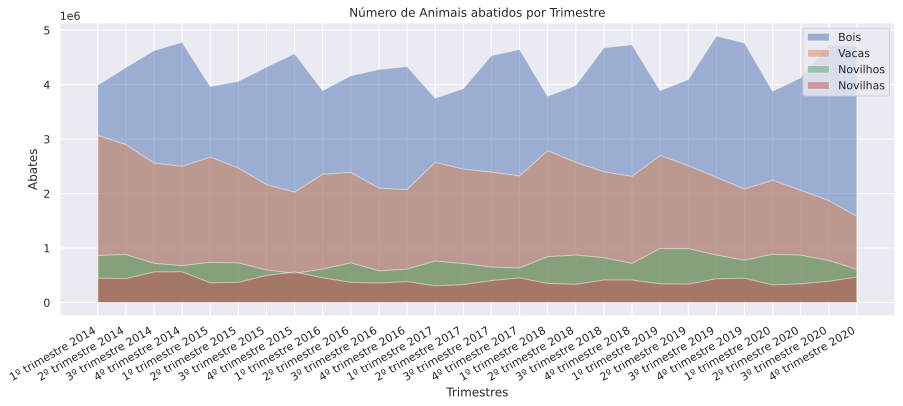

In [20]:
# Plotar quantidade de abates por trimestre
width = 0.3
labels = list(df_final.Trimestre)
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize = (15,6))
ax.fill_between(x, df_final.Bois, width, label='Bois', alpha=0.5)
ax.fill_between(x , df_final.Vacas, width, label='Vacas',alpha=0.5)
ax.fill_between(x, df_final.Novilhos, width, label='Novilhos',alpha=0.5)
ax.fill_between(x, df_final.Novilhas, width, label='Novilhas',alpha=0.5)

ax.set_ylabel('Abates')
ax.set_xlabel('Trimestres')
ax.set_title('Número de Animais abatidos por Trimestre')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.autofmt_xdate()
plt.show()